# Raport z projektu 2 - klasteryzacja
Grupa: Kacper Staroń, Jakub Szypuła, Anna Urbala

## Wstęp teoretyczny

### Na czym polega klasteryzacja?
Klasteryzacja polega na szukaniu skupień w zbiorze. Pozwala znaleźć naturalne podziały, wyodrębnić pewne struktury.

### Przykładowe algorytmy
Jednymi z najbardziej popularnych algorytmów są:

- **K-means** - iteracyjnie przypisuje punkty do skupień (do punktów wybranych jako środki), na podstawie otrzymanych skupień wylicza nowe ich środki; trzeba samemu dobrać liczbę skupień
- **hierarchiczne** (z różnymi typami połączeń klastrów) - dzieli istniejące klastry na kolejne klastry, póki odległość między nimi nie jest za mała (odległość zależy od typu połączenia, minimalną odległość można zdefiniować samemu)
- **DBSCAN** - znajduje punkty o wysokiej gęstości i na ich podstawie rozszerza klastry

### Ocena *jakości* klastrowania
Istnieje wiele różnych metryk oceny jakości klastrowania. Każda z nich zwraca uwagę na coś innego, dlatego powinny być dobierane na podstawie tego, co chcemy osiągnąć przez klastrowanie. Oto kilka przykładów:

- **metryka silhouette** - mierzy, jak dobrze pasują punkty do klastrów, niestety premiuje okrągłe klastry
- **indeks Daviesa-Bouldina** - miara podobieństwa klastra z najbardziej podobnym klastrem, podobieństwo liczone na podstawie odległości między klastrami i wewnątrz klastrów
- **różne miary odnośnie odległości między klastrami/w klastrze** - porównanie różnych miar (średnia ogległość między klastrami, najmniejsza odległość między klastrami, odległość punktu od środka klastra) daje nam pewną możliwość oceny klastrowania z uwzględnieniem parametrów, na których nam najbardziej zależy


## Opis zbioru danych
Wybrany przez nas zbiór danych to: [A study of Asian Religious and Biblical Texts Data Set](https://archive.ics.uci.edu/ml/datasets/A+study+of++Asian+Religious+and+Biblical+Texts). Dotyczy świętych tekstów różnych religii.

Składa się z 3 plików dotyczących tych samych danych, ale w innym formacie.

- `Complete_data .txt` - zawiera nieobrobiony tekst ksiąg
- `AllBooks_baseline_DTM_Unlabelled.csv` - tekst ksiąg w reprezentacji *bag-of-words* - słowa to kolumny, księgi wiersze, wartości w komórkach to liczba wystąpień danego słowa w księdze
- `AllBooks_baseline_DTM_Labelled.csv` - jak wyżej, ale z podpisem ksiąg

## Cel projektu
Celem projektu jest znalezienie sensownego podziału między księgami. Być może podział ten będzie w jakimś stopniu zgodny z podziałem na religie.

## Opis rozwiązania
Pierwszym problemem, który musieliśmy rozwiązać była obróbka oryginalnego tekstu. Niestety przez to, że pewne słowa występują bardzo rzadko, mogło być dość problematyczne operowanie na całej tabeli *AllBooks_baseline_DTM_Unlabelled*. Postanowiliśmy położyć pewien nacisk na zliczenie częstotliwości występowania słów w księgach.

[nltk_data] Downloading package stopwords to /home/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


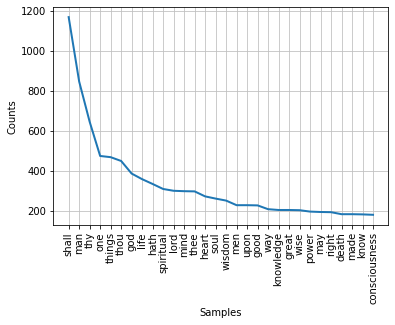

In [3]:
f = open('AsianReligionsData/Complete_data .txt')
content = f.read()
lines = content.split("\n")
data = []

# wybranie tylko linii z danymi
for i in range(len(lines)):
    if i % 2 == 1:
        data.append(lines[i])

f.close()

import nltk
from nltk.probability import FreqDist

# najczestsze slowa

def tokenize(text):
    words = nltk.word_tokenize(text)
    return [word.lower() for word in words if word.isalpha()]

def word_frequency(words):
    return FreqDist(words)

# stop words, ktore nalezy odfiltrowac
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Czestotliwosci zsumowane ze wszystkich ksiag

data_str = " ".join(data)
words_str = tokenize(data_str)
filtered_words_str = [word for word in words_str if word not in stop_words]
filtered_freq_str = word_frequency(filtered_words_str)
filtered_freq_str.plot(30, cumulative=False)

Powyższy wykres zasugerował nam również, że porównywanie słów poza TOP ok. 30-50 pod kątem częstotliwości prawdopodobnie nie ma sensu, gdyż nie będą występowały w prawie żadnej księdze. Być może warto spróbować porównywania korpusów.

Zainteresowało nas również, jakie słowa są najpopularniejsze w zależności od księgi.

[nltk_data] Downloading package stopwords to /home/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/anna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


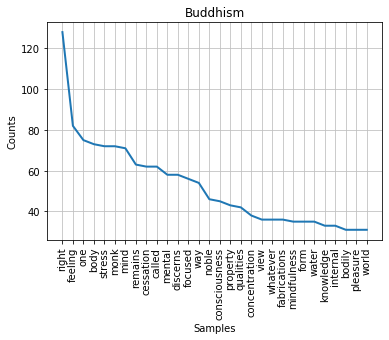

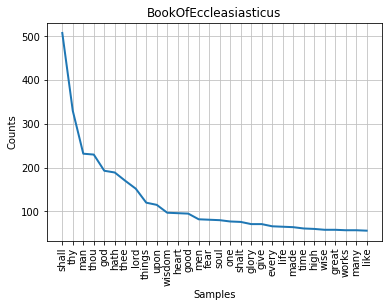

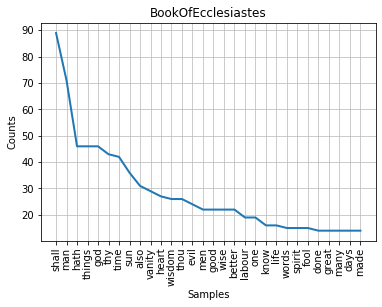

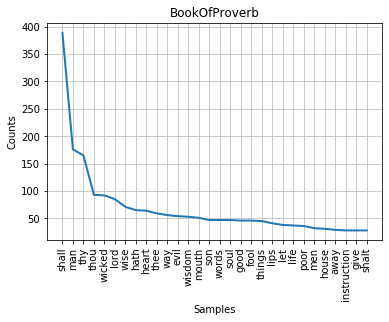

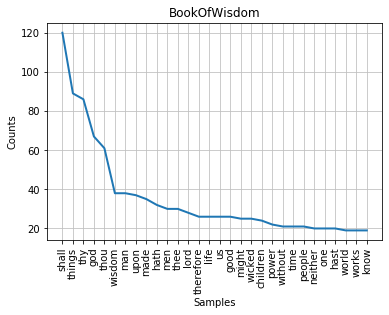

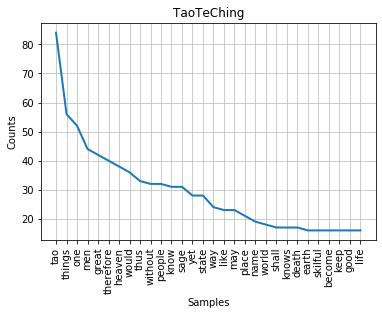

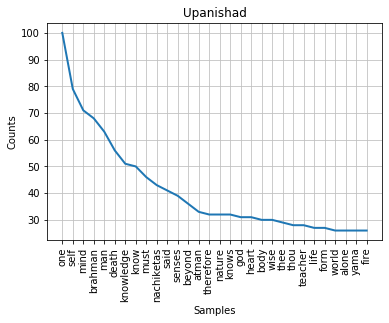

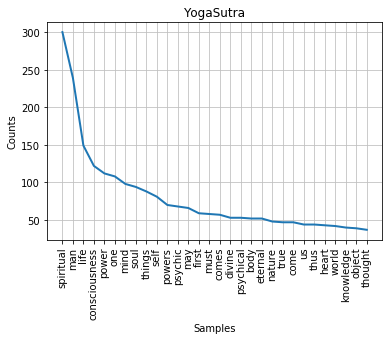

In [9]:
import re
f = open('AsianReligionsData/labels.txt')
lcontent = f.read()
llines = lcontent.split("\n")
labels = []

# wybranie tylko linii z danymi
for l in llines:
    labels.append(l)
        
f.close()
labels.pop()

labels_general = []
for l in labels:
    labels_search = re.search('(.+)_', l)
    labels_general.append(labels_search.group(1))
groups = set(labels_general)

group_ids = {}
for g in groups:
    tmp = [i for i in range(len(labels_general)) if labels_general[i] == g]
    group_ids[g] = tmp

import copy
books = {}
for g in groups:
    tmp = ""
    for i in group_ids[g]:
        tmp += data[i]
    books[g] = copy.copy(tmp)
    
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
# oczyszczenie ze stopwords
stop_words = set(stopwords.words("english"))

categories = ['Buddhism', 'BookOfEccleasiasticus', 'BookOfEcclesiastes', 'BookOfProverb', 'BookOfWisdom', 'TaoTeChing', 'Upanishad', 'YogaSutra']

for category in categories:
    cat_words_str = tokenize(books[category])
    cat_filtered_words_str = [word for word in cat_words_str if word not in stop_words]
    cat_filtered_freq_str = word_frequency(cat_filtered_words_str)
    cat_filtered_freq_str.plot(30, cumulative=False, title=category)

### Jak liczyć odległości?
Zdefiniowaliśmy 2 metody liczenia odległości między klastrami:

- cały tekst (z wyłączeniem stop words) przekształcony do miar TF-IDF i na tych miarach klasyczna odległość euklidesowa
- ograniczenie tekstu do $k$ najczęściej występujących słów (w naszym przypadku przyjęliśmy $k=30$) i na tym analogiczne operacje

In [16]:
import string
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

def process_whole_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
    
def get_first_i_without_order(text, i, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
        
    freq = FreqDist(tokens)
    most_comm = freq.most_common(i)
    tokens = [token[0] for token in most_comm]
    
    return tokens

from scipy.spatial import distance
import numpy as np

# def two_class

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

def clusters_num(X, label):
    return len(set(label))

def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def prepare_X(texts, process_function):
    vectorizer = TfidfVectorizer(tokenizer=process_function,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    return vectorizer.fit_transform(texts)

import pandas as pd
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans


metrices = {
            'min dist between clusters': min_interclust_dist,
            'mean dist in clust': mean_inclust_dist,
            'std dev dist in clust': std_dev_of_inclust_dist,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
            'davies-bouldin': davies_bouldin_score,
            'clusters num': clusters_num
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
          'Mini Batch KMeans': MiniBatchKMeans,
          'Kmeans': KMeans
         }

def calculate_metrics(X, cluster_num):
    df = pd.DataFrame()
    for model_key in models:
        for metric_key in metrices:
            df.loc[model_key, metric_key] = count_clustering_scores(X=X, cluster_num=cluster_num,
                                                                    model=models[model_key],
                                                                    score_fun=metrices[metric_key])
    return df

### Wartości metryk dla wstępnych modeli

In [31]:
# Get whole text
X = prepare_X(data, process_whole_text).toarray()
whole_text_metrics = calculate_metrics(X, 3) # dosc dobre wartosci dawalo rowniez n=8
whole_text_metrics

/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/anna/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/anna/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWar

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin,clusters num
Agglomerative ward linkage,0.667068,1.159602,0.132652,0.816676,0.037849,3.263464,3.0
Agglomerative complete linkage,0.667068,1.193291,0.138670,0.832920,0.010989,4.028249,3.0
Agglomerative average linkage,0.852063,1.123899,0.167949,0.749137,0.034225,2.483833,3.0
Agglomerative single linkage,1.000000,NaN,NaN,0.311238,-0.000251,0.953096,3.0
Mini Batch KMeans,0.483280,1.211756,0.123055,0.856638,0.054131,4.932039,3.0
Kmeans,0.637202,1.194398,0.125751,0.839296,0.053890,3.740224,3.0


In [44]:
# Get first 30
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
calculate_metrics(X, 10)

/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/anna/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/anna/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/anna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWar

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin,clusters num
Agglomerative ward linkage,0.478933,0.658365,0.226952,0.488231,0.323363,1.270449,10.0
Agglomerative complete linkage,0.440409,0.710792,0.134446,0.532736,0.282012,1.446030,10.0
Agglomerative average linkage,0.494142,0.595802,0.276128,0.443627,0.298544,1.250900,10.0
Agglomerative single linkage,0.665383,NaN,NaN,0.116205,0.000082,1.239330,10.0
Mini Batch KMeans,0.414123,0.677687,0.204880,0.497958,0.328521,1.156509,10.0
Kmeans,0.455740,0.637418,0.180616,0.485948,0.335518,1.147380,10.0


W przypadku procesowania całego tekstu metryka silhouette dała nam bardzo niskie wartości, w przypadku top 30 słów znacznie lepsze, ale nieco sprzeczne z indeksem Daviesa-Bouldina. 

Postanowiliśmy jednak sprawdzić jeszcze bardzo popularne algorytmy DBSCAN i GMM.

#### DBSCAN

In [22]:
from sklearn import cluster, mixture

X = prepare_X(data, process_whole_text).toarray()
eps_list = np.arange(0.1, 1, 0.1)
df = pd.DataFrame()
for eps in eps_list:
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X)
    df.loc[eps, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[eps, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for ", metric_key, eps)
df

/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


failed for  silhouette 0.1
failed for  davies-bouldin 0.1
failed for  silhouette 0.2
failed for  davies-bouldin 0.2
failed for  silhouette 0.30000000000000004
failed for  davies-bouldin 0.30000000000000004
failed for  silhouette 0.4
failed for  davies-bouldin 0.4


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
0.1,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.2,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.3,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.4,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.5,2.0,0.533469,0.915165,0.405571,0.633499,-0.030633,1.556112
0.6,3.0,0.548840,0.865496,0.323055,0.596172,-0.022660,1.712393
0.7,5.0,0.633533,0.850090,0.249306,0.573131,-0.029162,1.910902
0.8,7.0,0.649848,0.891919,0.199291,0.601810,-0.005624,2.101353
0.9,10.0,0.710173,1.000851,0.164401,0.677092,0.037307,2.686207


In [20]:
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
eps_list = np.arange(0.1, 1, 0.1)
df = pd.DataFrame()
for eps in eps_list:
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X)
    df.loc[eps, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[eps, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for ", metric_key, eps)
df

/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
0.1,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.2,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.3,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.4,33.0,0.412582,0.067941,0.216107,0.050334,0.419838,1.037136
0.5,40.0,0.380407,0.192560,0.234998,0.148261,0.522180,1.164041
0.6,15.0,0.417129,0.414437,0.405827,0.309569,0.157025,2.062636
0.7,4.0,0.591547,0.566451,0.570819,0.389698,0.001176,1.931544
0.8,3.0,0.838272,0.411164,0.581474,0.295838,0.001540,1.623308
0.9,2.0,1.000000,0.616319,0.616319,0.443617,-0.056503,1.947414


Niestety liczba $>20$ klastrów nas raczej nie interesuje, więc będziemy się raczej trzymać 3-10.

#### GMM

In [24]:
X = prepare_X(data, process_whole_text).toarray()
df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for", metric_key, n)
df

/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


failed for silhouette 1
failed for davies-bouldin 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
1,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
2,2.0,0.767523,1.183476,0.149325,0.835472,0.044869,2.854261
3,3.0,0.637202,1.193882,0.129132,0.842435,0.053726,3.802643
4,4.0,0.567902,1.211677,0.121084,0.854687,0.055656,4.661434
5,5.0,0.633533,1.198633,0.110304,0.843998,0.062370,3.981607
6,6.0,0.567902,1.206674,0.099149,0.849259,0.066139,4.010558
7,7.0,0.567902,1.186421,0.097486,0.833679,0.062060,3.833562
8,8.0,0.567902,1.167609,0.105557,0.819402,0.053970,3.608051
9,9.0,0.567902,1.202863,0.097961,0.845112,0.061185,3.967755


In [25]:
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for", metric_key, n)
df

/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


failed for silhouette 1
failed for davies-bouldin 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
1,1.0,inf,1.172193,0.000000,0.835972,NaN,NaN
2,2.0,0.466978,1.114335,0.059496,0.807023,0.105446,3.390252
3,3.0,0.511497,1.049549,0.031156,0.769036,0.150930,2.537146
4,4.0,0.469149,0.972991,0.132843,0.706962,0.129987,2.501287
5,5.0,0.408704,0.955707,0.055922,0.693469,0.156887,2.293578
6,6.0,0.469149,0.883534,0.094005,0.645035,0.209674,2.042706
7,7.0,0.390689,0.834472,0.059356,0.617116,0.245114,1.788053
8,8.0,0.478933,0.764430,0.092912,0.562896,0.276393,1.538603
9,9.0,0.391464,0.779031,0.032664,0.572854,0.267667,1.492006


Dla $n=8$ (czyli tyle, ile jest ksiąg!) mamy całkiem sensowne wartości.